# Campo fluido generado por un torbellino individual en presencia de una pared
Suponiendo una configuración como la mostrada en la Figura 1, con tres manantiales de intensidad $Q$ situados en el plano $z=0$ y a una distancia equidistante $a$, determinar el campo de velocidades y de presiones, así como las líneas de corriente y valor de la función de corriente $\Psi$.

<p align="center">
  <img width="800" src=./images/Grid_vs_Singularity_Drela.png>
<br><b>Método de malla discretizada frente a método de singularidades. <br>Imagen modificada de <i>"Flight Vehicle Aerodynamics"</i> (MIT Press, 2014)</b>
</p>

### Código Python para el cálculo del flujo potencial
En los siguientes párrafos se presenta una propuesta de cálculo numérico para el modelado discreto del flujo potencial. Existen muchas formas de realizar este cálculo, en este texto se presenta una alternativa sencilla que hace uso del módulo *NumPy* de Python, así como una representación gráfica de la función de corriente y el campo de velocidades.
Se parte del código desarrollado inicialmente para el Óvalo de Rankine, y se modifica adecuadamente la función *velocity_field* para representar el campo fluido generado por tres manantiales colocados de forma simétrica respecto al eje $x=0$ y de misma intensidad.

Nótese que en lo que corresponde al texto escrito en este documento, se usan variables en **negrita** para denotar vectores o matrices.

Junto a este documento se dispone de códigos MatLab o Python para su ejecución independiente, así como del Notebook original. 

Del mismo modo, se puede ejecutar de forma online a través del siguiente enlace: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/AMartinezCava/pyAero/HEAD?labpath=Notebook_RANKINE.ipynb)

In [1]:
# 1. Importación de módulos
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# 2. Definición de las funciones de cálculo del campo de velocidades
def velocity_field_source(x, z, Q, x_s, z_s):
    """
    Calcula el campo de velocidades inducido por una serie finita de manantiales.
    
    Parámetros:
    x, z -- coordenadas en el plano xz. Estas variables pueden ser tanto matrices, como vectores, como puntos discretos.
    Q -- magnitud de los manantiales (vector)
    x_s, z_s -- coordenadas de los torbellinos (vectores)
    
    Devuelve:
    u, w -- Componentes del campo de velocidades. Será del mismo tipo que la variable de entrada x y z.
            Si x y z son matrices, u y w contendrán el campo de velocidades completo. Si son puntos discretos, u y w 
            contendrán el valor de la velocidad en dichos puntos.
    """
    u = np.zeros_like(x, dtype='f8')
    w = np.zeros_like(z, dtype='f8')
    N = len(Q)
    for i in range(N):
        r = np.sqrt((x - x_s[i])**2 + (z - z_s[i])**2)
        u += Q[i] * (x - x_s[i]) / (2 * np.pi * r**2)
        w += Q[i] * (z - z_s[i]) / (2 * np.pi * r**2)
    return u, w

La función *velocity_field* toma como entrada las coordenadas **x** e **z** en el plano xz (nótese que pueden ser tanto matrices o vectores, como puntos discretos), la magnitud **Q** de los manantiales, y las coordenadas **x_s**, **z_s** de las singularidades. La función devuelve las componentes **u** y **w** del campo de velocidades.

Para calcular las componentes del campo de velocidades, se utiliza un bucle *for* que considera cada una de las singularidades, y calcula la contribución de cada uno de ellos en las componentes **u** y **w** utilizando la formulación matemática correspondiente (que puede ser deducida analíticamente a partir de los contenidos teóricos de la asignatura). 

Por ejemplo, la formulación matemática utilizada aqui para calcular la velocidad horizontal inducida por un manantial de intensidad $Q$, que se encuentra localizado en $(x_s, z_s)$, en un punto del espacio, $p$, situado a una distancia radial $r$, es la siguiente:
$$ U = \frac{Q}{2\pi r}\sin{\theta} = \frac{Q}{2\pi r} \frac{(z_p-z_s)}{r}$$

Podemos utilizar esta función para calcular el campo de velocidades en los distintos ejes del sistema de referencia empleado, tanto a nivel vectorial como a nivel puntual, y usar esos datos para visualizar la solución en un gráfico.

In [3]:
# Definimos la distancia entre manantiales y su intensidad
Q = 10
a = 3

# Aplicamos el método de las imágenes. Se puede generar un vector unidad y multiplicar por el valor escalar Q
Q_v = np.ones(3)*Q
x_s = np.array([-a, 0, a])
z_s = np.zeros(3)

# Se definen también sus coordenadas en el plano complejo, para el cálculo del potencial.
t_s = x_s + 1j*z_s
num_sources = len(Q_v)

# Definimos una malla para las coordenadas x e z
nx, nz = 60, 60
x = np.linspace(-10, 10, nx)
z = np.linspace(-10, 10, nz)
Xm, Zm = np.meshgrid(x, z)
Tm = Xm + 1j*Zm

# Calculamos las componentes u y v del campo de velocidades inducido por los manantiales o sumideros
u, w = velocity_field_source(Xm, Zm, Q_v, x_s, z_s)

# Construimos la funcion potencial
pot = 0
for s in range(num_sources):
    pot += Q_v[s]*np.log(Tm - t_s[s]) / (2*np.pi)

# De la función potencial extraemos tanto el potencial de velocidades (Phi) como la función de corriente (Psi)
phi = pot.real
psi = pot.imag

Una vez calculados el campo de velocidades, se calcula la función potencial de la forma habitual. Se recuerda que $f(t) = \Phi - i\Psi$, por lo que tras construir $f(t)$ es sencillo extraer tanto el potencial de velocidades, $\Phi$, como la función de corriente, $\Psi$.

Tras la fase de cálculo, es conveniente representar gráficamente la solución. Para ello hacemos uso de las funciones *contourf* y *contour* de Matplotlib, para representar el campo de la Función Potencial ($\Phi$), la Función de Corriente ($\Psi$), y la línea de corriente correspondiente a $\Psi=0$.

Por último, empleamos la función *quiver* para representar el campo de velocidades vectorial de forma más visual. Por defecto, esta función representa la longitud de los vectores de forma inversa a su magnitud, por lo que aquí se realiza una normalización previa.
Aunque sabemos que $\dot{f}(t)= \Phi_x - i \Phi_z = U - iW$, disponemos del campo de velocidades calculado previamente, en las variables **u** y **w**.

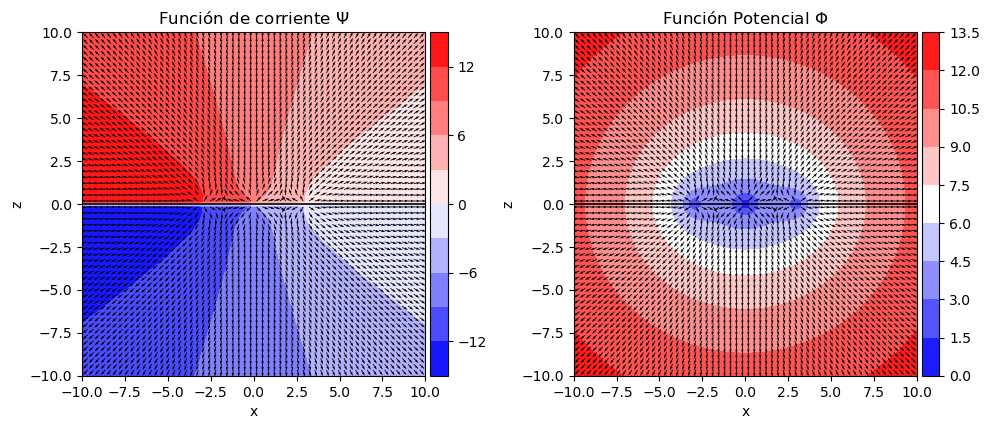

In [4]:
# Visualizamos la función de corriente y la función potencial
fig, axes = plt.subplots(1, 2, figsize=(10,8))                        # Creamos la figura
ax1, ax2 = axes.flatten()         

dividerPSI = make_axes_locatable(ax1)                                  # Ajustamos la posición de la barra de niveles
caxPSI = dividerPSI.append_axes('right', size='5%', pad=0.05)
cont = ax1.contourf(Xm, Zm, psi, 10, cmap='bwr')                       # Pintamos los contornos
ax1.contour(Xm, Zm, psi, levels=[0], colors=['black'], linewidths=1.2) # Representamos la línea de corriente psi=0    
fig.colorbar(cont, cax=caxPSI, orientation='vertical')                 # Pintamos la barra de niveles
ax1.set_title(r'Función de corriente $\Psi$')

dividerPHI = make_axes_locatable(ax2)                                  # Ajustamos la posición de la barra de niveles
caxPHI = dividerPHI.append_axes('right', size='5%', pad=0.05)
cont = ax2.contourf(Xm, Zm, phi, 10, cmap='bwr')                       # Pintamos los contornos
ax2.contour(Xm, Zm, psi, levels=[0], colors=['black'], linewidths=1.2) # Representamos la línea de corriente psi=0    
fig.colorbar(cont, cax=caxPHI, orientation='vertical')                 # Pintamos la barra de niveles
ax2.set_title(r'Función Potencial $\Phi$')

N = np.sqrt(u**2 + w**2)                                           
ax1.quiver(Xm, Zm, u/N, w/N, scale=50)                                 # Representamos el campo vectorial normalizado
ax2.quiver(Xm, Zm, u/N, w/N, scale=50)     

for ax in axes:
    ax.set_xlabel('x')                                                 # Etiquetamos de forma apropiada, y mostramos en pantalla
    ax.set_ylabel('z')
    ax.set_aspect('equal','box')
plt.tight_layout()

La representación de la línea de corriente correspondiente a $\Psi=0$ permite, en este caso, visualizar los puntos de remanso de la configuración propuesta.
Se recomienda jugar con la posición de los manantiales para observar la variación de éstos (inclusive la formación del punto de remanso triple si el manantial original está equidistante de las condiciones de contorno).

De forma similar al proceso antes realizado, podríamos representar el campo de velocidades tanto horizontal como vertical:

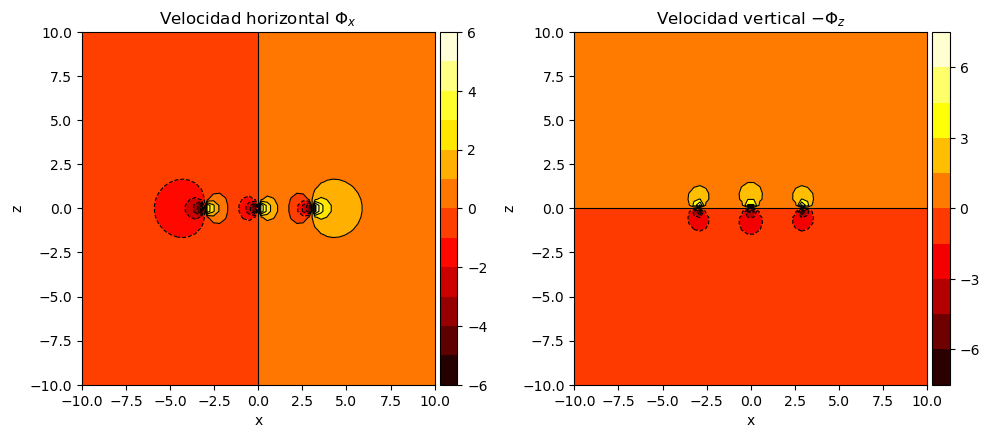

In [5]:
# Visualizamos el campo de velocidades
fig, axes = plt.subplots(1,2, figsize=(10,8)) 
ax1, ax2 = axes.flatten()                                             # Creamos la figura, con dos plots integrados

dividerU = make_axes_locatable(ax1)                                   # Ajustamos la posición de la barra de niveles en U
caxU = dividerU.append_axes('right', size='5%', pad=0.05)
dividerV = make_axes_locatable(ax2)                                   # Ajustamos la posición de la barra de niveles en W
caxV = dividerV.append_axes('right', size='5%', pad=0.05)

ax1.set_title(r'Velocidad horizontal $\Phi_x$')
cont = ax1.contourf(Xm, Zm, u, 10, cmap='hot')                        # Pintamos los contornos de U
ax1.contour(Xm, Zm, u, levels=10, colors=['black'], linewidths=0.8)   # Representamos lineas de isocontornos
fig.colorbar(cont, cax=caxU, orientation='vertical')                  # Pintamos la barra de niveles

ax2.set_title(r'Velocidad vertical $-\Phi_z$')
cont = ax2.contourf(Xm, Zm, w, 10, cmap='hot')                        # Pintamos los contornos
ax2.contour(Xm, Zm, w, levels=10, colors=['black'], linewidths=0.8)   # Representamos la línea de corriente psi=0    
fig.colorbar(cont, cax=caxV, orientation='vertical')                  # Pintamos la barra de niveles

# ax1.quiver(Xm, Zm, u/N, w/N, scale=50)                                # Representamos el campo vectorial normalizado
# ax2.quiver(Xm, Zm, u/N, w/N, scale=50)    

for ax in axes:
    ax.set_xlabel('x')                                                # Etiquetamos de forma apropiada, y mostramos en pantalla
    ax.set_ylabel('z')
    #ax.set(xlim=(-3, -1), ylim=(-1, 1))
    ax.set_aspect('equal','box')
plt.tight_layout()
plt.show()